In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint

from polynomial_nets import CP_L3, CP_L3_sparse, NCP_L3, CP, Chebyshev, Chebyshev_L3
import polynomial_nets as pn
import poly_utils as ut 

from poly_VAE import Flatten, UnFlatten, VAE_CP_L3, VAE_CP_L3_sparse, VAE_CP_L3_sparse_LU, loss_fn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import pandas as pd
import dataframe_image as dfi

import uqtestfuns as uqtf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from Cuda import DeviceDataLoader

import torchquad
from torchquad import MonteCarlo, VEGAS, set_up_backend
import copy
import polynomial_nets_chebyshev as pnc
import polynomial_nets_legendre as pnl
import polynomial_nets_CP as pncp
import test_functions_1D as tf1
import test_functions_2D as tf2
import sys, inspect
import os
import ot

In [28]:
def wasserstein_distance(p, q):
    wasserstein_sliced = ot.sliced_wasserstein_distance(p, q, seed=None)
    return wasserstein_sliced

In [2]:
torch.cuda.empty_cache() 
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
loss_fn = nn.MSELoss()
optimizer = torch.optim.Rprop
analytic = False
UQTF = True

In [3]:
import uqtestfuns as uqtf

list = uqtf.list_functions()

 No.      Constructor       Spatial Dimension          Application          Description
-----  ------------------  -------------------  --------------------------  ----------------------------------------------------------------------------
  1         Ackley()                M           optimization, metamodeling  Ackley function from Ackley (1987)
  2        Borehole()               8           metamodeling, sensitivity   Borehole function from Harper and Gupta (1983)
  3    DampedOscillator()           8           metamodeling, sensitivity   Damped oscillator model from Igusa and Der Kiureghian (1985)
  4         Flood()                 8           metamodeling, sensitivity   Flood model from Iooss and Lemaître (2015)
  5        Ishigami()               3                  sensitivity          Ishigami function from Ishigami and Homma (1991)
  6       OTLCircuit()              6           metamodeling, sensitivity   Output transformerless (OTL) circuit model from Ben-Ari and Steinber

In [4]:
#1D test params
if analytic == True:

    N = 10000
    LEARNING_RATE = 1e-4
    BATCH_SIZE = 64
    NUM_EPOCHS = 5
    RANK = 1
    DEGREE = 10
    IN_DIM = 1
    OUT_DIM = 1
    
    arguments = [DEGREE, IN_DIM, RANK, OUT_DIM]



In [5]:
#UQ test params
if UQTF == True:
    N = 10000
    LEARNING_RATE = 1e-4
    BATCH_SIZE = 64
    NUM_EPOCHS = 5
    RANK = 10
    DEGREE = 10
    IN_DIM = 8
    OUT_DIM = 1

    arguments = [DEGREE, IN_DIM, RANK, OUT_DIM]



In [6]:
ackley = uqtf.Ackley(8)
borehole = uqtf.Borehole()
damped_oscillator = uqtf.DampedOscillator()
flood = uqtf.Flood()

In [7]:
uq_functions = [ackley, borehole, damped_oscillator, flood]

In [8]:
arg_list = []
for i in uq_functions:
    in_dim  = i.spatial_dimension
    arguments = [DEGREE, in_dim, RANK, OUT_DIM]
    arg_list.append(arguments)

In [9]:
if IN_DIM == 1:
    functions, function_names = ut.get_functions('test_functions_1D')
    datasets = [ut.create_loaders(N, IN_DIM, fun, BATCH_SIZE, device, split=0.9) for fun in functions]
    test_datasets = [ut.generate_data(N, IN_DIM, fun) for fun in functions]
elif IN_DIM == 2:
    functions, function_names = ut.get_functions('test_functions_2D')
    datasets = [ut.create_loaders(N, IN_DIM, fun, BATCH_SIZE, device, split=0.9) for fun in functions]

In [10]:
if analytic == True:
    models, model_names = ut.get_models('polynomial_nets_legendre', arguments, device)
    models = [ut.Regression(model, IN_DIM, loss_fn).to(device) for model in models]

In [11]:
'''if UQTF == True:
    models, model_names = ut.get_models('polynomial_nets_CP', arguments, device)
    models = [ut.Regression(model, IN_DIM, loss_fn).to(device) for model in models]
    function_names = [i.name for i in uq_functions]
    datasets = [ut.create_loaders_uqtf(N, fun, BATCH_SIZE, device, split=0.9, target_scaler=MinMaxScaler())for fun in uq_functions]
    test_datasets = [ut.generate_dataset_uqtf(fun, N, MinMaxScaler())for fun in functions]'''

"if UQTF == True:\n    models, model_names = ut.get_models('polynomial_nets_CP', arguments, device)\n    models = [ut.Regression(model, IN_DIM, loss_fn).to(device) for model in models]\n    function_names = [i.name for i in uq_functions]\n    datasets = [ut.create_loaders_uqtf(N, fun, BATCH_SIZE, device, split=0.9, target_scaler=MinMaxScaler())for fun in uq_functions]\n    test_datasets = [ut.generate_dataset_uqtf(fun, N, MinMaxScaler())for fun in functions]"

In [12]:
if UQTF == True:
    models = [ ut.get_models('polynomial_nets_CP', i, device)[0] for i in arg_list]
    _, model_names = ut.get_models('polynomial_nets_CP', arg_list[0], device)
    #print(models)
    models = np.array(models).T
    for i in range(len(models)):
        for j in range(len(uq_functions)):
            models[i][j] = ut.Regression(models[i][j], loss_fn).to(device)

    datasets = [ut.create_loaders_uqtf(N, fun, BATCH_SIZE, device, split=0.9, target_scaler=MinMaxScaler()) for fun in uq_functions]
    test_datasets = [ut.generate_dataset_uqtf(fun, N, MinMaxScaler())for fun in uq_functions]
    function_names = [i.name for i in uq_functions]

for i in datasets[2][0]:
    print(i.shape)
    out = models[2][2](i)
    break

In [ ]:
if UQTF == True:
    mse_array = np.zeros_like(models)
    linf_array = np.zeros_like(models)
    for i in range(len(models)):
        for j in range(len(uq_functions)):
            #print(i,j)
            #print(ensemble[i][j])
            #print(optimizer_list[j])
            model, history, losses, mse, l_inf = ut.train_model_uqtf(NUM_EPOCHS, LEARNING_RATE, models[i][j], datasets[j][0], datasets[j][1], test_datasets[j][0], test_datasets[j][1], loss_fn, opt_func=torch.optim.Rprop, seed = 44)
            mse_array[i,j] = mse
            linf_array[i,j] = l_inf

In [15]:
uqtf_df_linf = pd.DataFrame(linf_array, index= model_names, columns =function_names )
uqtf_df_mse = pd.DataFrame(mse_array, index= model_names, columns =function_names )

In [16]:
uqtf_df_linf

,Ackley,Borehole,DampedOscillator,Flood
CP,7.130607,70.178938,853.8431,7.663339
CP_sparse_L,5.537459,96.464661,403.289876,3.459214
CP_sparse_LU,5.481548,76.675531,420.938766,2.331252
CP_sparse_U,5.371311,82.333749,541.996482,3.33938
CP_sparse_degree,5.779718,93.785141,635.294769,1.975404


In [17]:
uqtf_df_mse

,Ackley,Borehole,DampedOscillator,Flood
CP,0.448639,78.955331,5023.902348,0.764836
CP_sparse_L,0.267437,80.190611,2514.233358,0.101888
CP_sparse_LU,0.260244,111.99582,2883.506092,0.080832
CP_sparse_U,0.259349,127.894133,3484.831792,0.386945
CP_sparse_degree,0.389796,59.414815,3531.805157,0.104382


In [29]:
if UQTF == True:
    distances = np.zeros_like(models)

    for i in range(len(models)):
        for j in range(len(uq_functions)):
            model = models[i,j].to('cpu')
            test_dataset = test_datasets[j][0].to('cpu')
            outputs = model(test_dataset[:, :-1].to('cpu')).to('cpu').detach().numpy()
            target_scaler = test_datasets[j][1]
            outputs = target_scaler.inverse_transform(outputs)
            test_target = test_dataset[:, -1:].to('cpu').detach().numpy()
            test_target = target_scaler.inverse_transform(test_target)
            distance = wasserstein_distance(test_target, outputs)
            distances[i,j] = distance
        
            
            fig1 = plt.figure()
            plt.hist(test_target, bins="auto", color="#8da0cb", alpha = 0.9)
            plt.hist(outputs, bins='auto', alpha = 0.5)
            #plt.xlim(-300, 300)
            #plt.ylim(0, 600)
            plt.title('Model:'+ model_names[i] +', Function:'+ function_names[j])
            #plt.title(Optimizer_name[j])
            plt.xlabel("$\mathcal{M}(\mathbf{X})$ vs $\mathcal{G}(\mathbf{X})$")
            plt.ylabel("Counts [-]")
            plt.gcf().set_dpi(150);
            plt.savefig('Images/histogram_'+ model_names[i] + '_' + function_names[j] + '.png', dpi=150)
            plt.close()

In [30]:
df_distances = pd.DataFrame(distances, index= model_names, columns =function_names )

In [31]:
df_distances

,Ackley,Borehole,DampedOscillator,Flood
CP,0.398266,2.268622,19.982854,0.458397
CP_sparse_L,0.309078,2.60985,18.665994,0.086343
CP_sparse_LU,0.314506,2.803966,20.986257,0.084006
CP_sparse_U,0.299266,3.160102,17.23206,0.178048
CP_sparse_degree,0.33945,3.23391,15.70601,0.09867


In [35]:
if UQTF == True:
    param_count = np.zeros_like(models)

    for i in range(len(models)):
        for j in range(len(uq_functions)):
            model = models[i,j]
            param_count[i,j] = ut.non_zero_count(model)

In [36]:
df_params= pd.DataFrame(param_count, index= model_names, columns =function_names )

In [37]:
df_params

,Ackley,Borehole,DampedOscillator,Flood
CP,tensor(811),tensor(811),tensor(711),tensor(811)
CP_sparse_L,tensor(531),tensor(531),tensor(501),tensor(531)
CP_sparse_LU,tensor(739),tensor(739),tensor(648),tensor(739)
CP_sparse_U,tensor(371),tensor(371),tensor(291),tensor(371)
CP_sparse_degree,tensor(451),tensor(451),tensor(396),tensor(451)


In [32]:
models[0][0]

Regression(
  (model): CP(
    (U1): Linear(in_features=8, out_features=10, bias=False)
    (U2): Linear(in_features=8, out_features=10, bias=False)
    (U3): Linear(in_features=8, out_features=10, bias=False)
    (U4): Linear(in_features=8, out_features=10, bias=False)
    (U5): Linear(in_features=8, out_features=10, bias=False)
    (U6): Linear(in_features=8, out_features=10, bias=False)
    (U7): Linear(in_features=8, out_features=10, bias=False)
    (U8): Linear(in_features=8, out_features=10, bias=False)
    (U9): Linear(in_features=8, out_features=10, bias=False)
    (U10): Linear(in_features=8, out_features=10, bias=False)
    (layer_C): Linear(in_features=10, out_features=1, bias=True)
  )
  (loss_function): MSELoss()
)

In [ ]:
#n = len(models)
ensemble = [[] for _ in range(len(models))]

In [ ]:
for i in range(len(models)):
    for j in range(len(datasets)):
        model_clone = copy.deepcopy(models[i])
        ensemble[i].append(model_clone)
ensemble = np.array(ensemble)

In [ ]:
mse_array = np.zeros_like(ensemble)
linf_array = np.zeros_like(ensemble)
for i in range(len(models)):
    for j in range(len(datasets)):
        #print(ensemble[i][j])
        #print(optimizer_list[j])
        model, history, losses, mse, l_inf = ut.train_model(NUM_EPOCHS, LEARNING_RATE, ensemble[i][j], datasets[j][0], datasets[j][1], test_datasets[j], loss_fn, opt_func=torch.optim.Rprop, seed = 44)
        mse_array[i,j] = mse
        linf_array[i,j] = l_inf

In [ ]:
df_linf = pd.DataFrame(linf_array, index= model_names, columns =function_names )
df_mse = pd.DataFrame(mse_array, index= model_names, columns =function_names )

In [ ]:
#for j in range(len(datasets)):
    #print(ensemble[1][j].model.layer_C.bias)
    #print(ensemble[0][j].model.layer_C.bias)

/tmp/ipykernel_80452/1563148598.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1 = plt.figure()


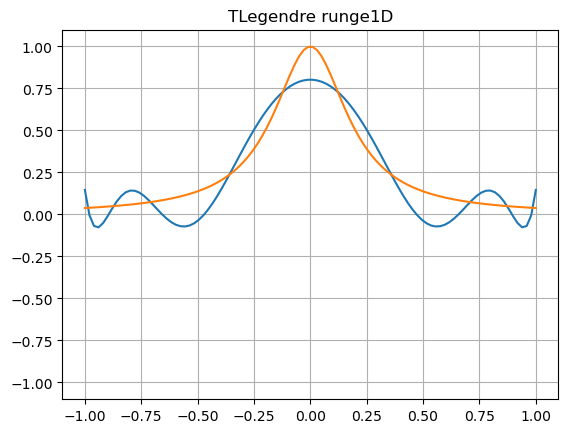

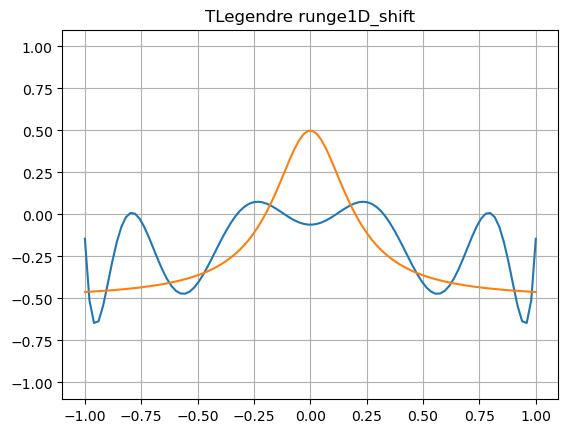

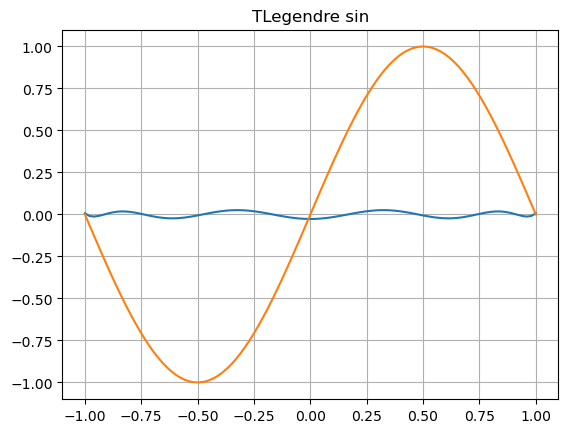

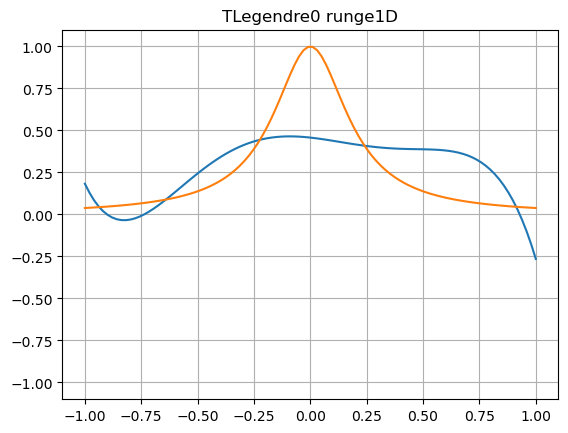

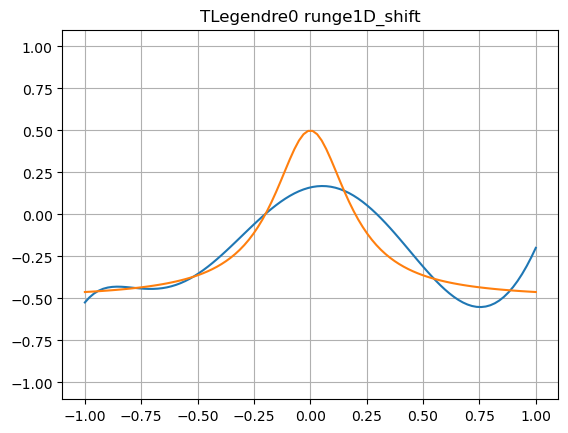

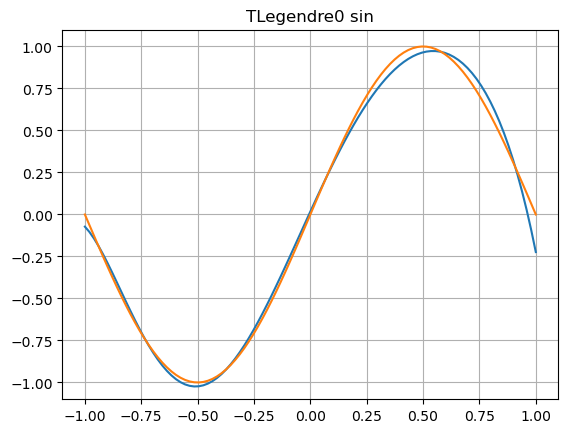

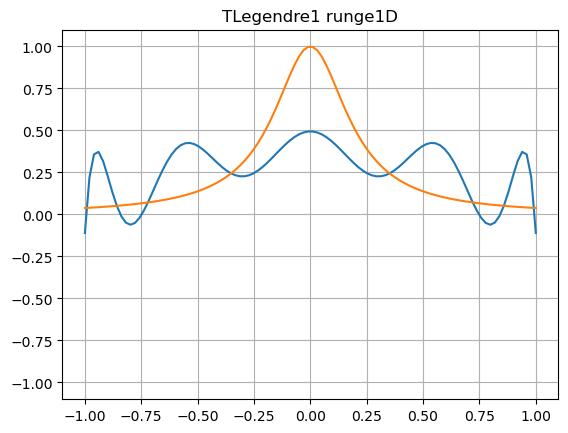

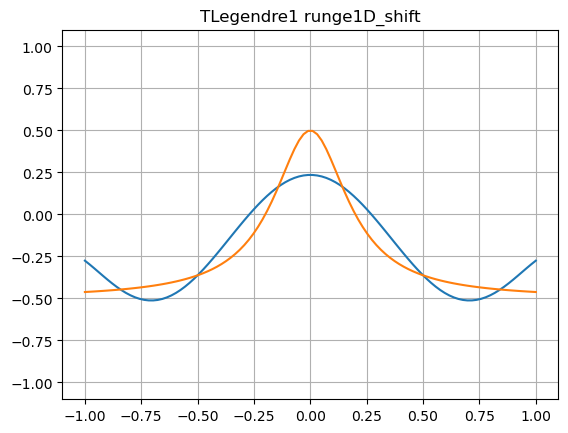

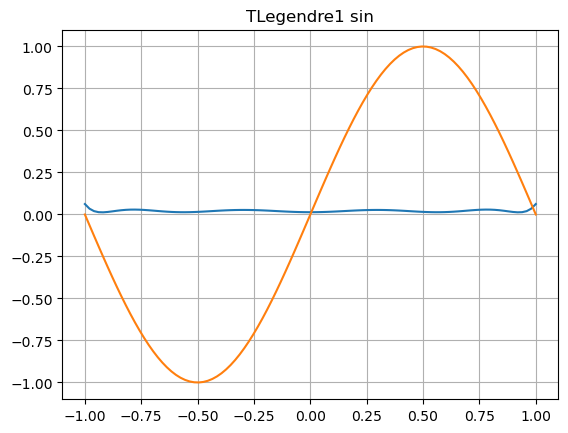

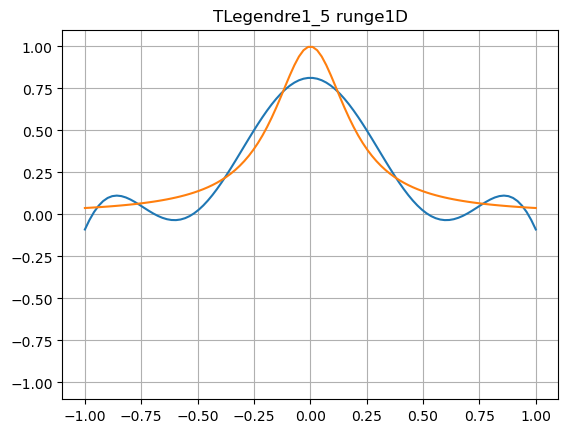

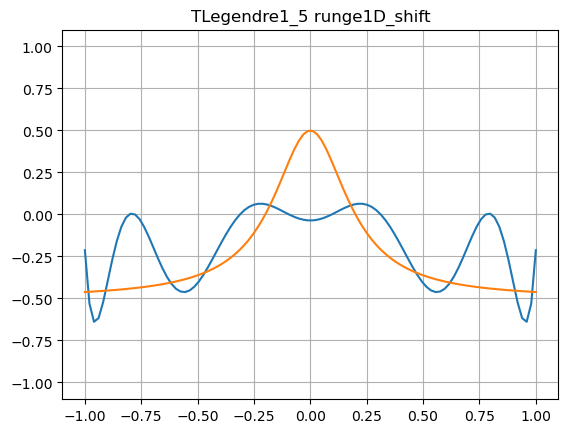

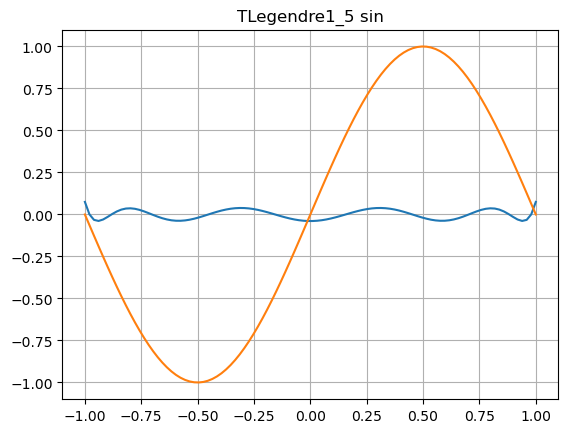

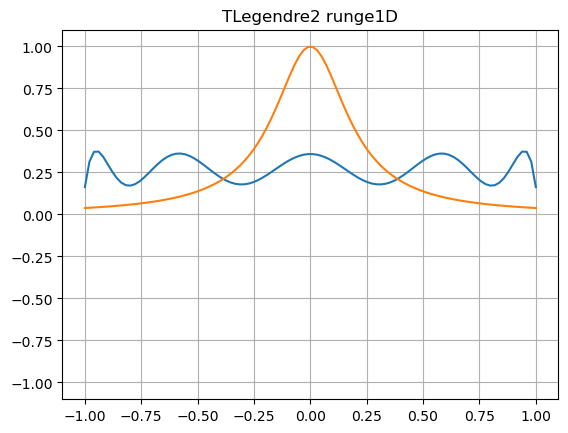

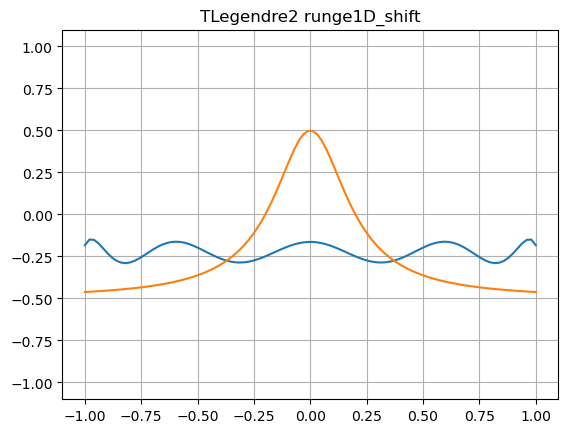

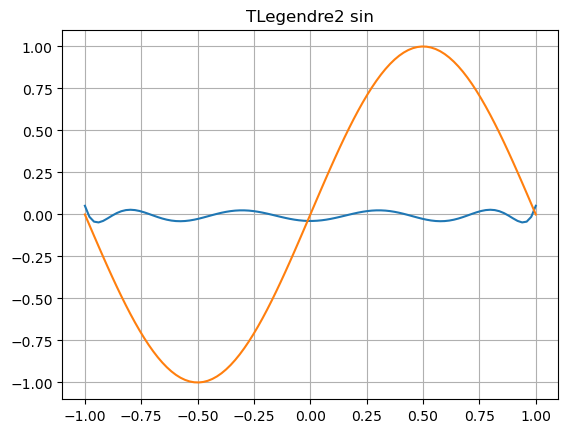

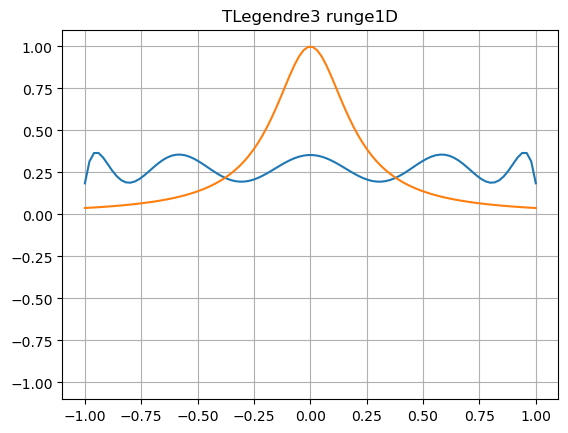

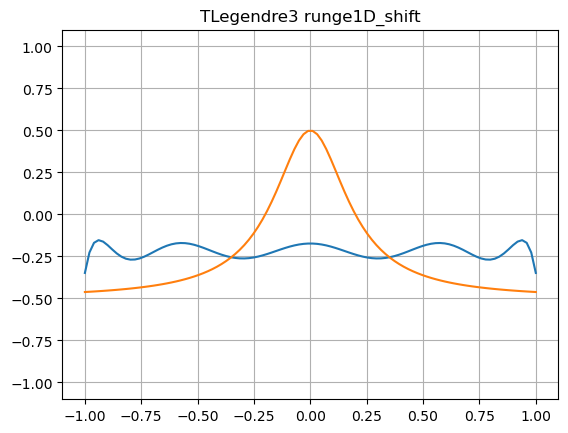

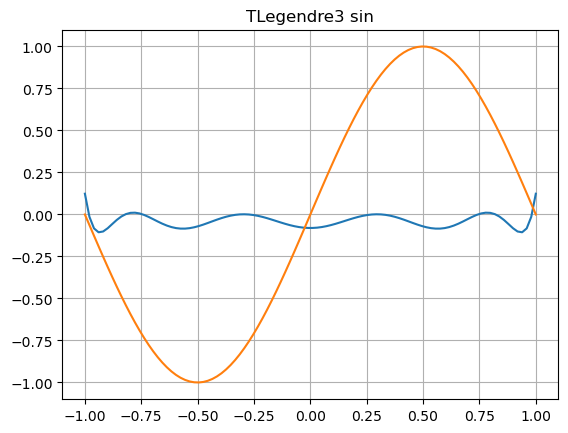

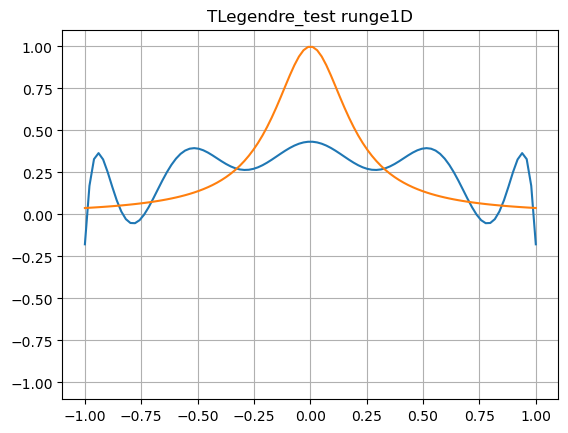

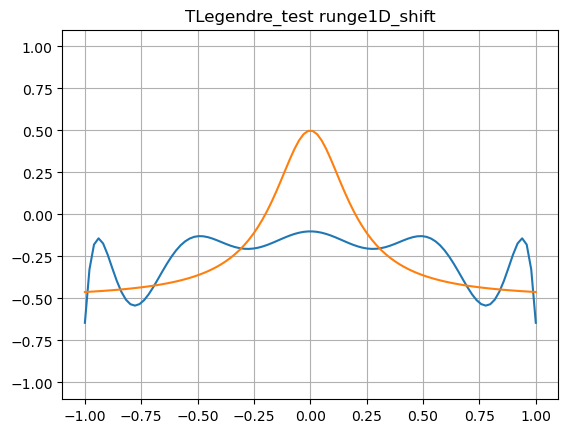

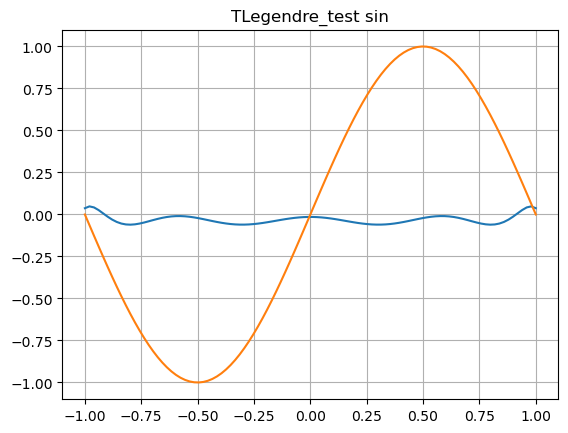

In [ ]:
if IN_DIM == 1.2:
    input = torch.linspace(-1, 1, 100)
    for i in range(len(models)):
        for j in range(len(datasets)):
            #legend = []  
            fig1 = plt.figure()
    
            plt.plot(input.numpy(), ensemble[i][j](input)[:,0].detach().numpy())
            plt.plot(input.numpy(), functions[j](input))
            plt.title(model_names[i] + ': Test Function' + functions[j].__name__)
            #plt.plot(input.numpy(), model_clone(input)[:,0].detach().numpy())
    #plt.plot(input.numpy(), sin(input))
    #legend = legend + ['T' + str(i.degree)]

    #plt.legend(legend)
            plt.xlim(-1.1, 1.1)
            plt.ylim(-1.1, 1.1)
            plt.grid()
            #plt.legend

In [ ]:
model = pn.Chebyshev(DEGREE, IN_DIM, RANK, OUT_DIM).to(device)
#model = pn.Chebyshev_norm(DEGREE, IN_DIM, RANK, OUT_DIM).to(device)
model = pnc.Chebyshev_test(DEGREE, IN_DIM, RANK, OUT_DIM).to(device)
#model = pn.Legendre(DEGREE, IN_DIM, RANK, OUT_DIM).to(device)
#model = Legendre_test(DEGREE, IN_DIM, RANK, OUT_DIM).to(device)
#model = pn.CP(DEGREE, IN_DIM, RANK, OUT_DIM).to(device)
model = ut.Regression(model, IN_DIM, loss_fn).to(device)
model_clone = copy.deepcopy(model)
#optimizer = torch.optim.Adam
#optimizer = torch.optim.SGD
optimizer = torch.optim.Rprop

In [ ]:
model = pnl.Legendre_test(DEGREE, IN_DIM, RANK, OUT_DIM).to(device)
model = pnl.Legendre(DEGREE, IN_DIM, RANK, OUT_DIM).to(device)
model = pnl.Legendre0(DEGREE, IN_DIM, RANK, OUT_DIM).to(device)
model = pnl.Legendre1(DEGREE, IN_DIM, RANK, OUT_DIM).to(device)
model = pnl.Legendre2(DEGREE, IN_DIM, RANK, OUT_DIM).to(device)

In [ ]:
train_loader, val_loader = ut.create_loaders(N, IN_DIM, tf2.runge2D, BATCH_SIZE, device, split=0.9)
test_dataset = ut.generate_data(N, IN_DIM, tf2.runge2D)

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
outputs = ut.eval_model(model, test_dataset)

In [ ]:
model(test_dataset[:, :-1]).shape

torch.Size([10000, 1])

In [ ]:
#model, history, losses, mse, l_inf = ut.train_model(NUM_EPOCHS, LEARNING_RATE, model, train_loader, val_loader, test_dataset, loss_fn, opt_func=torch.optim.Rprop, seed = 44)

['Legendre', 'Legendre0', 'Legendre1', 'Legendre1_5', 'Legendre2', 'Legendre3', 'Legendre_test']


In [ ]:
def get_models(module, arguments):
    classes = [cls_name for cls_name, cls_obj in inspect.getmembers(sys.modules[module]) if inspect.isclass(cls_obj)]
    return [getattr(sys.modules[module], i)(*arguments) for i in classes]

In [ ]:
models = get_models('polynomial_nets_legendre', arguments)
functions = get_functions('test_functions_1D')

In [ ]:
print(len(functions))

3


In [ ]:
for i in range(len(models)):
    print(models[i](torch.randn(3,2)))
#fun_list[1](torch.randn(3,2))

tensor([[ 1.5118],
        [-0.3895],
        [ 2.0182]], grad_fn=<MmBackward0>)
tensor([[-0.4887],
        [-1.1218],
        [ 0.1215]], grad_fn=<AddmmBackward0>)
tensor([[0.2581],
        [0.3622],
        [0.6686]], grad_fn=<AddBackward0>)
tensor([[-14.4131],
        [  0.2329],
        [ -1.6183]], grad_fn=<MmBackward0>)
tensor([[  0.1199],
        [ -0.8452],
        [-21.2564]], grad_fn=<AddBackward0>)
tensor([[2.9011],
        [0.2945],
        [0.5111]], grad_fn=<AddmmBackward0>)
tensor([[-0.2375],
        [ 0.0111],
        [ 0.2119]], grad_fn=<MmBackward0>)


KeyError: 'test_functions'

0.009900990099009901